Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 15.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.7 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 6.6 MB 58.0 MB/s 
     |████████████████████████████████| 596 kB 79.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a5c7aa4388a27d3e67ff4b89739e345d8aba7adc7b304cf88be248cb30a52fec
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [3]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'I-problem', 'I-test', 'B-problem', 'I-treatment', 'O', 'B-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'I-problem', 'I-test', 'B-problem', 'I-treatment', 'O', 'B-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-treatment', 'I-problem', 'I-test', 'I-treatment', 'B-problem', 'O', 'B-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [4]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

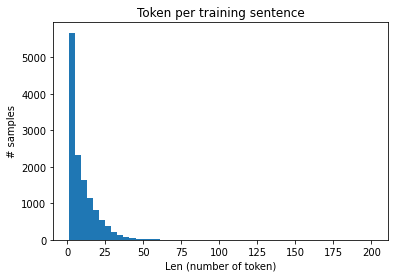

In [5]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

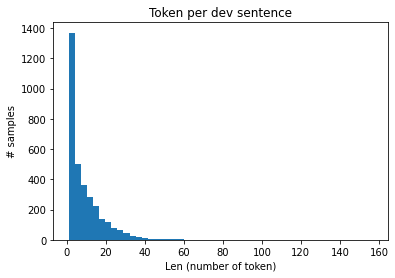

In [6]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

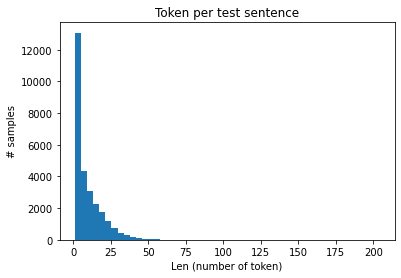

In [7]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [8]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

26574
motorvehicle
0
I-treatment


In [9]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [10]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.99235)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 100
Points in y_train before removal: 100


In [11]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [12]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[26677, 15043]
[5, 5]
[26541, 11219, 6180, 22212, 16868, 1937, 17165, 13060, 18604, 14508, 6907, 269, 2324, 27854]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[16884, 11900, 15043]
[5, 5, 5]
26574
0
I-test
Cuchkote
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 82.3 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 596 kB 96.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=2eb7f6de8517fdeb5664f39689dca398b5304bf076de2026cc60fe65bc02c76b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[26677, 15043]
[5, 5]
[26541, 11219, 6180, 22212, 16868, 1937, 17165, 13060, 18604, 14508, 6907, 269, 2324, 27854]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[16884, 11900, 15043]
[5, 5, 5]
26574
0
I-test
Cuchkote
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 64:
    TRAIN_BATCH_SIZE = 64
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 64:
    VALID_BATCH_SIZE = 64
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [21]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0701091289520264
Training loss epoch: 0.9747892141342163
Training accuracy epoch: 0.72
Validating model...
Validation Loss: 0.5744647190851324
Validation Accuracy: 0.8397379785247432
Training epoch: 2
Training loss per 100 training steps: 0.4412502646446228
Training loss epoch: 0.3829462412744761
Training accuracy epoch: 0.9099999999999998
Validating model...
Validation Loss: 0.570528454932512
Validation Accuracy: 0.8366742530345471
Training epoch: 3
Training loss per 100 training steps: 0.1360922008752823
Training loss epoch: 0.12577292881906033
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.45972464657297324
Validation Accuracy: 0.8547161920323685
Training epoch: 4
Training loss per 100 training steps: 0.028054961934685707
Training loss epoch: 0.033362134266644715
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.508150401653028
Validation Accuracy: 0.8427725256769375
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4668373824614618
Validation Accuracy: 0.8474939306684733
Validation duration: 3.12352535 minutes
F1-score (test): 29.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.24      0.07      0.11      1170
        test       0.77      0.20      0.31      2464
   treatment       0.45      0.33      0.38      1244

   micro avg       0.52      0.20      0.29      4878
   macro avg       0.49      0.20      0.27      4878
weighted avg       0.56      0.20      0.28      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.058528184890747
Training loss epoch: 0.8708513125777244
Training accuracy epoch: 0.74
Validating model...
Validation Loss: 0.6265924181423935
Validation Accuracy: 0.8329734671646436
Training epoch: 2
Training loss per 100 training steps: 1.0799109935760498
Training loss epoch: 0.45110896453261373
Training accuracy epoch: 0.85
Validating model...
Validation Loss: 0.48181653607125374
Validation Accuracy: 0.8449317226890756
Training epoch: 3
Training loss per 100 training steps: 0.14348652958869934
Training loss epoch: 0.14548647664487363
Training accuracy epoch: 0.9600000000000002
Validating model...
Validation Loss: 0.5049683737988565
Validation Accuracy: 0.8409245642701525
Training epoch: 4
Training loss per 100 training steps: 0.015960901975631714
Training loss epoch: 0.053465012833476065
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4676484728560728
Validation Accuracy: 0.8366402116402116
Training epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47327598367162327
Validation Accuracy: 0.8347059902890694
Validation duration: 3.1227971166666673 minutes
F1-score (test): 41.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.23      0.51      0.32      1170
        test       0.77      0.31      0.44      2464
   treatment       0.55      0.49      0.52      1244

   micro avg       0.42      0.40      0.41      4878
   macro avg       0.52      0.43      0.42      4878
weighted avg       0.58      0.40      0.43      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.93411123752594
Training loss epoch: 0.9724786359816789
Training accuracy epoch: 0.73
Validating model...
Validation Loss: 0.5390341936373243
Validation Accuracy: 0.8329783302209773
Training epoch: 2
Training loss per 100 training steps: 0.6309717893600464
Training loss epoch: 0.402406907081604
Training accuracy epoch: 0.8800000000000001
Validating model...
Validation Loss: 0.5522272890689326
Validation Accuracy: 0.84000058356676
Training epoch: 3
Training loss per 100 training steps: 0.03521493449807167
Training loss epoch: 0.09416508153080941
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.5127715804413253
Validation Accuracy: 0.837578781512605
Training epoch: 4
Training loss per 100 training steps: 0.04240657761693001
Training loss epoch: 0.027636712323874234
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5369038464976292
Validation Accuracy: 0.8397282524120759
Training epoch: 5
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5393789958001839
Validation Accuracy: 0.833175424853207
Validation duration: 3.1234503166666667 minutes
F1-score (test): 24.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.20      0.19      0.19      1170
        test       0.86      0.12      0.22      2464
   treatment       0.48      0.26      0.33      1244

   micro avg       0.40      0.17      0.24      4878
   macro avg       0.51      0.19      0.25      4878
weighted avg       0.61      0.17      0.24      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8808889389038086
Training loss epoch: 0.9843270927667618
Training accuracy epoch: 0.7700000000000001
Validating model...
Validation Loss: 0.5606307036736432
Validation Accuracy: 0.8329734671646436
Training epoch: 2
Training loss per 100 training steps: 0.42314380407333374
Training loss epoch: 0.3818014472723007
Training accuracy epoch: 0.86
Validating model...
Validation Loss: 0.49356068290916144
Validation Accuracy: 0.8256302521008403
Training epoch: 3
Training loss per 100 training steps: 0.18523859977722168
Training loss epoch: 0.08964723069220781
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5297085563926136
Validation Accuracy: 0.8372578197945845
Training epoch: 4
Training loss per 100 training steps: 0.0183736402541399
Training loss epoch: 0.022825507307425143
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5989805571004456
Validation Accuracy: 0.8424856053532525
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5103301959181273
Validation Accuracy: 0.8185746245483287
Validation duration: 3.122244999999998 minutes
F1-score (test): 28.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.18      0.46      0.26      1170
        test       0.78      0.23      0.35      2464
   treatment       0.52      0.11      0.18      1244

   micro avg       0.32      0.25      0.28      4878
   macro avg       0.49      0.26      0.27      4878
weighted avg       0.57      0.25      0.29      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9718074798583984
Training loss epoch: 1.0090458959341049
Training accuracy epoch: 0.71
Validating model...
Validation Loss: 0.5988001928609961
Validation Accuracy: 0.8329734671646436
Training epoch: 2
Training loss per 100 training steps: 0.2761545479297638
Training loss epoch: 0.41123935878276824
Training accuracy epoch: 0.8300000000000001
Validating model...
Validation Loss: 0.49337705560759004
Validation Accuracy: 0.8308288593215063
Training epoch: 3
Training loss per 100 training steps: 0.28017836809158325
Training loss epoch: 0.13882242552936078
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5426357154022244
Validation Accuracy: 0.8335862122626828
Training epoch: 4
Training loss per 100 training steps: 0.06002064421772957
Training loss epoch: 0.03677172027528286
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5425984164079031
Validation Accuracy: 0.8440077419856832
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5209487314094547
Validation Accuracy: 0.8202110504177959
Validation duration: 3.120642916666668 minutes
F1-score (test): 11.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.14      0.14      0.14      1170
        test       0.94      0.05      0.10      2464
   treatment       0.72      0.04      0.08      1244

   micro avg       0.25      0.07      0.11      4878
   macro avg       0.60      0.08      0.11      4878
weighted avg       0.69      0.07      0.11      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.261932849884033
Training loss epoch: 1.1019852757453918
Training accuracy epoch: 0.7299999999999999
Validating model...
Validation Loss: 0.6058838244746713
Validation Accuracy: 0.8333138811079988
Training epoch: 2
Training loss per 100 training steps: 0.4412965774536133
Training loss epoch: 0.42051112800836565
Training accuracy epoch: 0.8800000000000001
Validating model...
Validation Loss: 0.5342813502339756
Validation Accuracy: 0.8390863289760349
Training epoch: 3
Training loss per 100 training steps: 0.11880198866128922
Training loss epoch: 0.1351416408084333
Training accuracy epoch: 0.96
Validating model...
Validation Loss: 0.5450978585902382
Validation Accuracy: 0.8293261749144102
Training epoch: 4
Training loss per 100 training steps: 0.07753585278987885
Training loss epoch: 0.0399876506999135
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5243614888658711
Validation Accuracy: 0.830819133208839
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5344702461734414
Validation Accuracy: 0.827171373927281
Validation duration: 3.1236252999999956 minutes
F1-score (test): 28.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.23      0.34      0.27      1170
        test       0.75      0.18      0.29      2464
   treatment       0.65      0.18      0.28      1244

   micro avg       0.40      0.22      0.28      4878
   macro avg       0.54      0.23      0.28      4878
weighted avg       0.60      0.22      0.28      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.919525146484375
Training loss epoch: 0.985329869389534
Training accuracy epoch: 0.72
Validating model...
Validation Loss: 0.510402952339135
Validation Accuracy: 0.8305419389978212
Training epoch: 2
Training loss per 100 training steps: 0.5891498327255249
Training loss epoch: 0.3013048518449068
Training accuracy epoch: 0.9
Validating model...
Validation Loss: 0.5245331981602837
Validation Accuracy: 0.8338828586990351
Training epoch: 3
Training loss per 100 training steps: 0.10531290620565414
Training loss epoch: 0.07217101342976093
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.46385623076382804
Validation Accuracy: 0.8390911920323685
Training epoch: 4
Training loss per 100 training steps: 0.03088674321770668
Training loss epoch: 0.020309728430584074
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5414737728880901
Validation Accuracy: 0.843681917211329
Training epoch: 5
Training loss per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46826373471843974
Validation Accuracy: 0.8383431783536586
Validation duration: 3.1249339666666702 minutes
F1-score (test): 31.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.16      0.23      0.19      1170
        test       0.85      0.24      0.37      2464
   treatment       0.46      0.34      0.39      1244

   micro avg       0.38      0.26      0.31      4878
   macro avg       0.49      0.27      0.32      4878
weighted avg       0.58      0.26      0.33      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8721177577972412
Training loss epoch: 1.0612093567848206
Training accuracy epoch: 0.74
Validating model...
Validation Loss: 0.5930534133724138
Validation Accuracy: 0.8335716230936819
Training epoch: 2
Training loss per 100 training steps: 0.4223765432834625
Training loss epoch: 0.4081995993852615
Training accuracy epoch: 0.82
Validating model...
Validation Loss: 0.528775501777144
Validation Accuracy: 0.8354341736694677
Training epoch: 3
Training loss per 100 training steps: 0.255534291267395
Training loss epoch: 0.16249858364462852
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5016510071707707
Validation Accuracy: 0.8345053299097416
Training epoch: 4
Training loss per 100 training steps: 0.08695615082979202
Training loss epoch: 0.04248329387046397
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6169165016389361
Validation Accuracy: 0.8378754279489573
Training epoch: 5
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5169173327998983
Validation Accuracy: 0.8268529104561879
Validation duration: 3.1252773333333304 minutes
F1-score (test): 21.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.21      0.32      0.25      1170
        test       0.89      0.09      0.17      2464
   treatment       0.61      0.14      0.23      1244

   micro avg       0.33      0.16      0.22      4878
   macro avg       0.57      0.18      0.22      4878
weighted avg       0.65      0.16      0.20      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.34297776222229
Training loss epoch: 1.0474283158779145
Training accuracy epoch: 0.7
Validating model...
Validation Loss: 0.614816845632067
Validation Accuracy: 0.8329734671646436
Training epoch: 2
Training loss per 100 training steps: 0.21362963318824768
Training loss epoch: 0.38202258124947547
Training accuracy epoch: 0.8700000000000001
Validating model...
Validation Loss: 0.4863375086410373
Validation Accuracy: 0.8290003501400559
Training epoch: 3
Training loss per 100 training steps: 0.15174810588359833
Training loss epoch: 0.12207424715161323
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.46952632507857156
Validation Accuracy: 0.8498190943043884
Training epoch: 4
Training loss per 100 training steps: 0.10881389677524567
Training loss epoch: 0.028619573963806034
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5298260643201715
Validation Accuracy: 0.8492258014316838
Training epoch: 5
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4814522863814124
Validation Accuracy: 0.8458345683717254
Validation duration: 3.126620533333335 minutes
F1-score (test): 33.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.27      0.24      0.26      1170
        test       0.92      0.21      0.34      2464
   treatment       0.84      0.30      0.44      1244

   micro avg       0.57      0.24      0.34      4878
   macro avg       0.68      0.25      0.35      4878
weighted avg       0.74      0.24      0.35      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0728697776794434
Training loss epoch: 1.0733013540506362
Training accuracy epoch: 0.72
Validating model...
Validation Loss: 0.6149791677792867
Validation Accuracy: 0.8332798397136632
Training epoch: 2
Training loss per 100 training steps: 0.7567731142044067
Training loss epoch: 0.3906737767159939
Training accuracy epoch: 0.8600000000000001
Validating model...
Validation Loss: 0.5712693847861945
Validation Accuracy: 0.8366645269218799
Training epoch: 3
Training loss per 100 training steps: 0.21120920777320862
Training loss epoch: 0.15709196254611016
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.45664423762583267
Validation Accuracy: 0.843380407718643
Training epoch: 4
Training loss per 100 training steps: 0.10396411269903183
Training loss epoch: 0.046252996381372216
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6119085675945469
Validation Accuracy: 0.8354098583877996
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45534587234120677
Validation Accuracy: 0.8396655516034327
Validation duration: 3.1346974499999987 minutes
F1-score (test): 29.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.25      0.23      1170
        test       0.82      0.21      0.34      2464
   treatment       0.42      0.24      0.31      1244

   micro avg       0.42      0.23      0.30      4878
   macro avg       0.49      0.23      0.29      4878
weighted avg       0.58      0.23      0.31      4878



In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9367681741714478
Training loss epoch: 1.0072524776825538
Training accuracy epoch: 0.7307692307692307
Validating model...
Validation Loss: 0.5474918718431511
Validation Accuracy: 0.8351132119514473
Training epoch: 2
Training loss per 100 training steps: 0.32868772745132446
Training loss epoch: 0.3065741119476465
Training accuracy epoch: 0.8923076923076925
Validating model...
Validation Loss: 0.45866752722684073
Validation Accuracy: 0.8409488795518206
Training epoch: 3
Training loss per 100 training steps: 0.11315878480672836
Training loss epoch: 0.06537136428344709
Training accuracy epoch: 0.9846153846153847
Validating model...
Validation Loss: 0.4687957962354024
Validation Accuracy: 0.8464879007158419
Training epoch: 4
Training loss per 100 training steps: 0.017502328380942345
Training loss epoch: 0.03148735912803274
Training accuracy epoch: 0.9923076923076923
Validating model...
Validation Loss: 0.5866903814614988
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47978369194876264
Validation Accuracy: 0.8360557108175248
Validation duration: 2.061991783333333 minutes
F1-score (test): 24.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.37      0.23      0.28      1170
        test       0.88      0.10      0.18      2464
   treatment       0.40      0.25      0.31      1244

   micro avg       0.46      0.17      0.25      4878
   macro avg       0.55      0.19      0.25      4878
weighted avg       0.64      0.17      0.23      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.362820863723755
Training loss epoch: 0.9968087489788349
Training accuracy epoch: 0.7153846153846154
Validating model...
Validation Loss: 0.4883018229521957
Validation Accuracy: 0.8550322906940554
Training epoch: 2
Training loss per 100 training steps: 0.2761111557483673
Training loss epoch: 0.2199720230240088
Training accuracy epoch: 0.9615384615384617
Validating model...
Validation Loss: 0.469863892770281
Validation Accuracy: 0.8535198801742919
Training epoch: 3
Training loss per 100 training steps: 0.0483187735080719
Training loss epoch: 0.043675065506249666
Training accuracy epoch: 0.9923076923076923
Validating model...
Validation Loss: 0.49892382323741913
Validation Accuracy: 0.8424758792405851
Training epoch: 4
Training loss per 100 training steps: 0.02860158681869507
Training loss epoch: 0.01677183548991497
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.587869859793607
Validation Accuracy: 0.8394024276

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4845735485734487
Validation Accuracy: 0.8514654612691961
Validation duration: 2.0644816666666665 minutes
F1-score (test): 33.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.24      0.22      0.23      1170
        test       0.89      0.21      0.35      2464
   treatment       0.84      0.32      0.47      1244

   micro avg       0.55      0.24      0.34      4878
   macro avg       0.66      0.25      0.35      4878
weighted avg       0.72      0.24      0.35      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.395781993865967
Training loss epoch: 0.9449296341492579
Training accuracy epoch: 0.730769230769231
Validating model...
Validation Loss: 0.5623585149353626
Validation Accuracy: 0.8354438997821351
Training epoch: 2
Training loss per 100 training steps: 0.1665356457233429
Training loss epoch: 0.28912364347622943
Training accuracy epoch: 0.9000000000000001
Validating model...
Validation Loss: 0.46386226924026713
Validation Accuracy: 0.8476890756302521
Training epoch: 3
Training loss per 100 training steps: 0.05924089998006821
Training loss epoch: 0.06617993904420963
Training accuracy epoch: 0.9923076923076923
Validating model...
Validation Loss: 0.5134591036567501
Validation Accuracy: 0.8544146825396826
Training epoch: 4
Training loss per 100 training steps: 0.03200378641486168
Training loss epoch: 0.021837237004477244
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4690934299838309
Validation Accuracy: 0.8467602

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47301115381910847
Validation Accuracy: 0.8398305174457995
Validation duration: 2.055683783333332 minutes
F1-score (test): 27.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.27      0.28      0.27      1170
        test       0.91      0.09      0.17      2464
   treatment       0.56      0.35      0.43      1244

   micro avg       0.44      0.20      0.28      4878
   macro avg       0.58      0.24      0.29      4878
weighted avg       0.67      0.20      0.26      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.8375422954559326
Training loss epoch: 1.0663823972527797
Training accuracy epoch: 0.7538461538461539
Validating model...
Validation Loss: 0.5907438508435792
Validation Accuracy: 0.8342086834733893
Training epoch: 2
Training loss per 100 training steps: 0.4106961190700531
Training loss epoch: 0.394761118464745
Training accuracy epoch: 0.8923076923076922
Validating model...
Validation Loss: 0.438728156043034
Validation Accuracy: 0.842174369747899
Training epoch: 3
Training loss per 100 training steps: 0.1437457650899887
Training loss epoch: 0.10158026619599415
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5004551746681625
Validation Accuracy: 0.841245525988173
Training epoch: 4
Training loss per 100 training steps: 0.009703547693789005
Training loss epoch: 0.01954002553023971
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5422423546220742
Validation Accuracy: 0.8544438608776844
Training e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46005133135865134
Validation Accuracy: 0.8359286782971996
Validation duration: 2.0530703166666666 minutes
F1-score (test): 19.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.08      0.11      1170
        test       0.93      0.19      0.32      2464
   treatment       0.21      0.01      0.02      1244

   micro avg       0.59      0.12      0.20      4878
   macro avg       0.45      0.09      0.15      4878
weighted avg       0.58      0.12      0.20      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4434821605682373
Training loss epoch: 0.6841843156860425
Training accuracy epoch: 0.8307692307692307
Validating model...
Validation Loss: 0.5336218447077508
Validation Accuracy: 0.8375836445689387
Training epoch: 2
Training loss per 100 training steps: 0.35585421323776245
Training loss epoch: 0.19516804814338684
Training accuracy epoch: 0.9461538461538462
Validating model...
Validation Loss: 0.45156163123308446
Validation Accuracy: 0.8403264083411142
Training epoch: 3
Training loss per 100 training steps: 0.0317622609436512
Training loss epoch: 0.04052385265150896
Training accuracy epoch: 0.9923076923076923
Validating model...
Validation Loss: 0.536123563261593
Validation Accuracy: 0.8372967242452537
Training epoch: 4
Training loss per 100 training steps: 0.037991344928741455
Training loss epoch: 0.010025892845498255
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6020698231809279
Validation Accuracy: 0.83879

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4639328179743003
Validation Accuracy: 0.8367358641034327
Validation duration: 2.0476117500000024 minutes
F1-score (test): 29.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.32      0.35      0.34      1170
        test       0.83      0.20      0.32      2464
   treatment       0.33      0.16      0.21      1244

   micro avg       0.45      0.23      0.30      4878
   macro avg       0.49      0.24      0.29      4878
weighted avg       0.58      0.23      0.30      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.737060308456421
Training loss epoch: 0.8827271088957787
Training accuracy epoch: 0.7307692307692307
Validating model...
Validation Loss: 0.544297082751405
Validation Accuracy: 0.8397088001867413
Training epoch: 2
Training loss per 100 training steps: 0.24050483107566833
Training loss epoch: 0.3521794175299314
Training accuracy epoch: 0.8692307692307691
Validating model...
Validation Loss: 0.44822029331151175
Validation Accuracy: 0.851958839091192
Training epoch: 3
Training loss per 100 training steps: 0.13144008815288544
Training loss epoch: 0.09825229372542638
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4701206292591843
Validation Accuracy: 0.8584267040149394
Training epoch: 4
Training loss per 100 training steps: 0.019846264272928238
Training loss epoch: 0.03276502901616578
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4807700564463933
Validation Accuracy: 0.8513606831621537
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45707163490630964
Validation Accuracy: 0.84692404866757
Validation duration: 2.0787255666666664 minutes
F1-score (test): 32.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.31      0.24      0.27      1170
        test       0.78      0.14      0.23      2464
   treatment       0.53      0.45      0.49      1244

   micro avg       0.50      0.24      0.32      4878
   macro avg       0.54      0.28      0.33      4878
weighted avg       0.61      0.24      0.31      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0642056465148926
Training loss epoch: 0.9320607506311857
Training accuracy epoch: 0.7615384615384616
Validating model...
Validation Loss: 0.5649632414182028
Validation Accuracy: 0.8473827030812324
Training epoch: 2
Training loss per 100 training steps: 0.582314670085907
Training loss epoch: 0.2765601303141851
Training accuracy epoch: 0.9076923076923078
Validating model...
Validation Loss: 0.4795870637776805
Validation Accuracy: 0.8531989184562714
Training epoch: 3
Training loss per 100 training steps: 0.017147282138466835
Training loss epoch: 0.06173845616957316
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.43971136562964497
Validation Accuracy: 0.8418485449735449
Training epoch: 4
Training loss per 100 training steps: 0.03163604438304901
Training loss epoch: 0.01780908203755434
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4664135055214751
Validation Accuracy: 0.8550468798630564
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43263589566642485
Validation Accuracy: 0.8504641980013551
Validation duration: 2.055600616666667 minutes
F1-score (test): 39.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.28      0.28      0.28      1170
        test       0.87      0.19      0.32      2464
   treatment       0.47      0.69      0.56      1244

   micro avg       0.47      0.34      0.39      4878
   macro avg       0.54      0.39      0.38      4878
weighted avg       0.62      0.34      0.37      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7170016765594482
Training loss epoch: 0.9578305285137433
Training accuracy epoch: 0.7846153846153847
Validating model...
Validation Loss: 0.644192210599488
Validation Accuracy: 0.8311206427015251
Training epoch: 2
Training loss per 100 training steps: 0.7370821833610535
Training loss epoch: 0.3915258187514085
Training accuracy epoch: 0.8615384615384616
Validating model...
Validation Loss: 0.4964122371930702
Validation Accuracy: 0.8363727435418611
Training epoch: 3
Training loss per 100 training steps: 0.22133612632751465
Training loss epoch: 0.10156073808096923
Training accuracy epoch: 0.9846153846153847
Validating model...
Validation Loss: 0.5108900812326693
Validation Accuracy: 0.8284070572673513
Training epoch: 4
Training loss per 100 training steps: 0.04090961068868637
Training loss epoch: 0.033022303313303455
Training accuracy epoch: 0.9923076923076923
Validating model...
Validation Loss: 0.508433002467249
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5069263073857184
Validation Accuracy: 0.8286498913166215
Validation duration: 2.0633191333333305 minutes
F1-score (test): 14.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.27      0.20      0.23      1170
        test       0.92      0.05      0.10      2464
   treatment       0.69      0.07      0.12      1244

   micro avg       0.40      0.09      0.15      4878
   macro avg       0.63      0.11      0.15      4878
weighted avg       0.70      0.09      0.14      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2643420696258545
Training loss epoch: 0.7850610949099064
Training accuracy epoch: 0.7923076923076924
Validating model...
Validation Loss: 0.6236329937682432
Validation Accuracy: 0.8357502723311546
Training epoch: 2
Training loss per 100 training steps: 0.17118771374225616
Training loss epoch: 0.20249813565841088
Training accuracy epoch: 0.9000000000000001
Validating model...
Validation Loss: 0.5056183764747545
Validation Accuracy: 0.818588546529723
Training epoch: 3
Training loss per 100 training steps: 0.1258869618177414
Training loss epoch: 0.06497241501123287
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6096697721411201
Validation Accuracy: 0.8354147214441332
Training epoch: 4
Training loss per 100 training steps: 0.03164811059832573
Training loss epoch: 0.015408781366064571
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7001087314942304
Validation Accuracy: 0.8320543495175847
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5111300171939311
Validation Accuracy: 0.817457796973803
Validation duration: 2.0576966833333357 minutes
F1-score (test): 33.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.18      0.54      0.27      1170
        test       0.72      0.16      0.26      2464
   treatment       0.57      0.51      0.54      1244

   micro avg       0.32      0.34      0.33      4878
   macro avg       0.49      0.40      0.36      4878
weighted avg       0.55      0.34      0.33      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9435269832611084
Training loss epoch: 0.8957030446483538
Training accuracy epoch: 0.7230769230769231
Validating model...
Validation Loss: 0.6154982915111616
Validation Accuracy: 0.8219635076252723
Training epoch: 2
Training loss per 100 training steps: 0.5103159546852112
Training loss epoch: 0.24021989995470414
Training accuracy epoch: 0.9384615384615386
Validating model...
Validation Loss: 0.4999407036047356
Validation Accuracy: 0.8440028789293494
Training epoch: 3
Training loss per 100 training steps: 0.010808423161506653
Training loss epoch: 0.05266227569574347
Training accuracy epoch: 0.9923076923076923
Validating model...
Validation Loss: 0.5373584175226735
Validation Accuracy: 0.8157922891378774
Training epoch: 4
Training loss per 100 training steps: 0.014555757865309715
Training loss epoch: 0.019426904905300874
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5690462936957678
Validation Accuracy: 0.8421

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5073505279918512
Validation Accuracy: 0.8413522611788617
Validation duration: 2.06473238333333 minutes
F1-score (test): 27.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.30      0.17      0.22      1170
        test       0.87      0.11      0.19      2464
   treatment       0.55      0.36      0.44      1244

   micro avg       0.51      0.19      0.27      4878
   macro avg       0.58      0.21      0.28      4878
weighted avg       0.65      0.19      0.26      4878



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.993403434753418
Training loss epoch: 0.7665099581082662
Training accuracy epoch: 0.78
Validating model...
Validation Loss: 0.503553698460261
Validation Accuracy: 0.8350986227824463
Training epoch: 2
Training loss per 100 training steps: 0.06146640703082085
Training loss epoch: 0.17252286796768507
Training accuracy epoch: 0.9600000000000001
Validating model...
Validation Loss: 0.4208945415767969
Validation Accuracy: 0.8529071350762527
Training epoch: 3
Training loss per 100 training steps: 0.03710681572556496
Training loss epoch: 0.06864912083062033
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.4771407997491313
Validation Accuracy: 0.857799369747899
Training epoch: 4
Training loss per 100 training steps: 0.026326950639486313
Training loss epoch: 0.028475722763687372
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.49282821516195935
Validation Accuracy: 0.86025

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43604284035110913
Validation Accuracy: 0.8493632494918699
Validation duration: 2.0498336666666623 minutes
F1-score (test): 43.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.28      0.54      0.37      1170
        test       0.52      0.43      0.47      2464
   treatment       0.77      0.35      0.48      1244

   micro avg       0.44      0.44      0.44      4878
   macro avg       0.52      0.44      0.44      4878
weighted avg       0.53      0.44      0.45      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9465539455413818
Training loss epoch: 0.7723329059779644
Training accuracy epoch: 0.8
Validating model...
Validation Loss: 0.5587148122927722
Validation Accuracy: 0.8345199190787426
Training epoch: 2
Training loss per 100 training steps: 0.5138767957687378
Training loss epoch: 0.2657461111744245
Training accuracy epoch: 0.9200000000000002
Validating model...
Validation Loss: 0.4575129989899841
Validation Accuracy: 0.8470763305322129
Training epoch: 3
Training loss per 100 training steps: 0.07032288610935211
Training loss epoch: 0.05207601139942805
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6272638570152077
Validation Accuracy: 0.846157212885154
Training epoch: 4
Training loss per 100 training steps: 0.00753085408359766
Training loss epoch: 0.010335176453615228
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6059275757448346
Validation Accuracy: 0.8440126050420167
Training epoch: 5
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4643614517386865
Validation Accuracy: 0.8403933420844625
Validation duration: 2.0513601333333327 minutes
F1-score (test): 25.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.24      0.24      0.24      1170
        test       0.90      0.07      0.12      2464
   treatment       0.55      0.36      0.44      1244

   micro avg       0.41      0.18      0.25      4878
   macro avg       0.56      0.22      0.27      4878
weighted avg       0.65      0.18      0.23      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2785980701446533
Training loss epoch: 0.9718804856141409
Training accuracy epoch: 0.72
Validating model...
Validation Loss: 0.510492768942141
Validation Accuracy: 0.8356919156551509
Training epoch: 2
Training loss per 100 training steps: 0.0929756611585617
Training loss epoch: 0.25767854899168013
Training accuracy epoch: 0.9266666666666669
Validating model...
Validation Loss: 0.4602762612642026
Validation Accuracy: 0.8329734671646436
Training epoch: 3
Training loss per 100 training steps: 0.05318991094827652
Training loss epoch: 0.07088904740909735
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.5327044354349959
Validation Accuracy: 0.8470909197012139
Training epoch: 4
Training loss per 100 training steps: 0.03652138262987137
Training loss epoch: 0.018120121598864596
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5684164525831447
Validation Accuracy: 0.8486081932773109
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4762560782816123
Validation Accuracy: 0.827833883807588
Validation duration: 2.0486829166666665 minutes
F1-score (test): 35.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.20      0.52      0.29      1170
        test       0.62      0.32      0.42      2464
   treatment       0.67      0.23      0.34      1244

   micro avg       0.36      0.35      0.35      4878
   macro avg       0.50      0.36      0.35      4878
weighted avg       0.53      0.35      0.37      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.316500663757324
Training loss epoch: 0.8735021519164244
Training accuracy epoch: 0.7466666666666666
Validating model...
Validation Loss: 0.5334198439822477
Validation Accuracy: 0.8335910753190166
Training epoch: 2
Training loss per 100 training steps: 0.5854787230491638
Training loss epoch: 0.27967760351796944
Training accuracy epoch: 0.9133333333333333
Validating model...
Validation Loss: 0.6368265514280281
Validation Accuracy: 0.839412153750389
Training epoch: 3
Training loss per 100 training steps: 0.06486146152019501
Training loss epoch: 0.07665381996581952
Training accuracy epoch: 0.98
Validating model...
Validation Loss: 0.5525581024441064
Validation Accuracy: 0.8314513305322129
Training epoch: 4
Training loss per 100 training steps: 0.009198582731187344
Training loss epoch: 0.03355005718767643
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.6046751509694492
Validation Accuracy: 0.8467796

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5520881031536393
Validation Accuracy: 0.8238076586495032
Validation duration: 2.056233583333331 minutes
F1-score (test): 0.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       1.00      0.00      0.00      2464
   treatment       1.00      0.00      0.01      1244

   micro avg       1.00      0.00      0.00      4878
   macro avg       0.67      0.00      0.00      4878
weighted avg       0.76      0.00      0.00      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0414092540740967
Training loss epoch: 0.8822990814844768
Training accuracy epoch: 0.7333333333333333
Validating model...
Validation Loss: 0.5016320049762726
Validation Accuracy: 0.8339169000933707
Training epoch: 2
Training loss per 100 training steps: 0.6102477312088013
Training loss epoch: 0.23009665310382843
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.4738168880051258
Validation Accuracy: 0.8354438997821351
Training epoch: 3
Training loss per 100 training steps: 0.33431071043014526
Training loss epoch: 0.059545467421412465
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.47445374844120997
Validation Accuracy: 0.861782212885154
Training epoch: 4
Training loss per 100 training steps: 0.01650863140821457
Training loss epoch: 0.009202069571862618
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4667280044625787
Validation Accuracy: 0.85903

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4803504592704552
Validation Accuracy: 0.8594702743902439
Validation duration: 2.0618539499999997 minutes
F1-score (test): 48.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.24      0.35      0.28      1170
        test       0.81      0.43      0.56      2464
   treatment       0.69      0.55      0.61      1244

   micro avg       0.53      0.44      0.48      4878
   macro avg       0.58      0.44      0.48      4878
weighted avg       0.64      0.44      0.51      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0167298316955566
Training loss epoch: 0.7365628233800332
Training accuracy epoch: 0.8000000000000003
Validating model...
Validation Loss: 0.5229858528165257
Validation Accuracy: 0.8394364690320572
Training epoch: 2
Training loss per 100 training steps: 0.1696229726076126
Training loss epoch: 0.1876644888271888
Training accuracy epoch: 0.9466666666666668
Validating model...
Validation Loss: 0.4403240239503337
Validation Accuracy: 0.8394170168067226
Training epoch: 3
Training loss per 100 training steps: 0.04061805456876755
Training loss epoch: 0.03592342687770724
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.6110168011749492
Validation Accuracy: 0.8332944288826641
Training epoch: 4
Training loss per 100 training steps: 0.001440932392142713
Training loss epoch: 0.00923057747228692
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6436805619912989
Validation Accuracy: 0.8464587

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4462150421200527
Validation Accuracy: 0.8359560255758808
Validation duration: 2.0630618166666634 minutes
F1-score (test): 40.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.27      0.59      0.37      1170
        test       0.59      0.36      0.44      2464
   treatment       0.73      0.26      0.38      1244

   micro avg       0.42      0.39      0.41      4878
   macro avg       0.53      0.40      0.40      4878
weighted avg       0.55      0.39      0.41      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.894791841506958
Training loss epoch: 0.8736089676618576
Training accuracy epoch: 0.7466666666666667
Validating model...
Validation Loss: 0.5391823281260097
Validation Accuracy: 0.8366645269218799
Training epoch: 2
Training loss per 100 training steps: 0.26189881563186646
Training loss epoch: 0.24254579643408458
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.5140571839669171
Validation Accuracy: 0.8305224867724867
Training epoch: 3
Training loss per 100 training steps: 0.031721971929073334
Training loss epoch: 0.050122424773871896
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.6204228319373786
Validation Accuracy: 0.856870525988173
Training epoch: 4
Training loss per 100 training steps: 0.001889100531116128
Training loss epoch: 0.045730767243852215
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.5737339486094082
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5231470778515493
Validation Accuracy: 0.8470643137420958
Validation duration: 2.058578233333333 minutes
F1-score (test): 37.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.26      0.34      0.29      1170
        test       0.88      0.23      0.37      2464
   treatment       0.69      0.38      0.49      1244

   micro avg       0.50      0.30      0.37      4878
   macro avg       0.61      0.32      0.38      4878
weighted avg       0.68      0.30      0.38      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8519014120101929
Training loss epoch: 0.7929613431294759
Training accuracy epoch: 0.7466666666666665
Validating model...
Validation Loss: 0.4478076994419098
Validation Accuracy: 0.8528925459072518
Training epoch: 2
Training loss per 100 training steps: 0.24555277824401855
Training loss epoch: 0.13927540021638077
Training accuracy epoch: 0.9666666666666667
Validating model...
Validation Loss: 0.4921944696529239
Validation Accuracy: 0.8532135076252723
Training epoch: 3
Training loss per 100 training steps: 0.04126078635454178
Training loss epoch: 0.029855550080537797
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.7265931806143593
Validation Accuracy: 0.8513460939931528
Training epoch: 4
Training loss per 100 training steps: 0.007475815713405609
Training loss epoch: 0.015862101037055255
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.8607513179966048
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46941340035172524
Validation Accuracy: 0.845412008807588
Validation duration: 2.0589902000000015 minutes
F1-score (test): 33.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.22      0.22      1170
        test       0.73      0.38      0.50      2464
   treatment       0.83      0.05      0.09      1244

   micro avg       0.49      0.26      0.34      4878
   macro avg       0.59      0.22      0.27      4878
weighted avg       0.63      0.26      0.33      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1261696815490723
Training loss epoch: 0.8327236716945966
Training accuracy epoch: 0.78
Validating model...
Validation Loss: 0.47225364399891273
Validation Accuracy: 0.8397185262994087
Training epoch: 2
Training loss per 100 training steps: 0.18149390816688538
Training loss epoch: 0.2128894882897536
Training accuracy epoch: 0.9333333333333335
Validating model...
Validation Loss: 0.453368177893115
Validation Accuracy: 0.8458313881107998
Training epoch: 3
Training loss per 100 training steps: 0.031422123312950134
Training loss epoch: 0.04192754154404004
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.5679368324139539
Validation Accuracy: 0.8375739184562714
Training epoch: 4
Training loss per 100 training steps: 0.007243967615067959
Training loss epoch: 0.007935400198524198
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5575924284902274
Validation Accuracy: 0.8498579987550576
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46594220686152027
Validation Accuracy: 0.843386545844625
Validation duration: 2.0722447833333413 minutes
F1-score (test): 44.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.24      0.49      0.32      1170
        test       0.63      0.42      0.51      2464
   treatment       0.74      0.42      0.54      1244

   micro avg       0.45      0.44      0.45      4878
   macro avg       0.54      0.44      0.46      4878
weighted avg       0.56      0.44      0.47      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.842171311378479
Training loss epoch: 0.8191329419612885
Training accuracy epoch: 0.7733333333333333
Validating model...
Validation Loss: 0.6520560120835024
Validation Accuracy: 0.7937772331154683
Training epoch: 2
Training loss per 100 training steps: 0.3623269200325012
Training loss epoch: 0.2781787005563577
Training accuracy epoch: 0.9266666666666666
Validating model...
Validation Loss: 0.4457065255618563
Validation Accuracy: 0.833610527544351
Training epoch: 3
Training loss per 100 training steps: 0.30327802896499634
Training loss epoch: 0.09033567594985167
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.5017105124744714
Validation Accuracy: 0.837578781512605
Training epoch: 4
Training loss per 100 training steps: 0.0038729433435946703
Training loss epoch: 0.02390623401540021
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.533063168911373
Validation Accuracy: 0.8436965063

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45540168657209035
Validation Accuracy: 0.8338149983062331
Validation duration: 2.0724688333333234 minutes
F1-score (test): 30.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.37      0.28      1170
        test       0.70      0.22      0.34      2464
   treatment       0.82      0.19      0.31      1244

   micro avg       0.40      0.25      0.31      4878
   macro avg       0.58      0.26      0.31      4878
weighted avg       0.61      0.25      0.31      4878



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4369664192199707
Training loss epoch: 0.9407860686381658
Training accuracy epoch: 0.7444444444444447
Validating model...
Validation Loss: 0.5136446958663416
Validation Accuracy: 0.8351132119514473
Training epoch: 2
Training loss per 100 training steps: 0.22481660544872284
Training loss epoch: 0.1985719297081232
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.5921094651315727
Validation Accuracy: 0.7903779567382508
Training epoch: 3
Training loss per 100 training steps: 0.09250345826148987
Training loss epoch: 0.038168587126872607
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5520701349950304
Validation Accuracy: 0.8504512916277622
Training epoch: 4
Training loss per 100 training steps: 0.008726137690246105
Training loss epoch: 0.007959746975555189
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5520689282931533
Validation Accuracy: 0.8513655462184874
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5372416088012634
Validation Accuracy: 0.8273319289182475
Validation duration: 2.0653501333333377 minutes
F1-score (test): 6.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.62      0.11      0.19      1170
        test       0.79      0.02      0.04      2464
   treatment       1.00      0.00      0.00      1244

   micro avg       0.66      0.04      0.07      4878
   macro avg       0.80      0.04      0.08      4878
weighted avg       0.80      0.04      0.06      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.054741621017456
Training loss epoch: 0.8070775566415654
Training accuracy epoch: 0.7333333333333333
Validating model...
Validation Loss: 0.5202745240108639
Validation Accuracy: 0.8247014083411142
Training epoch: 2
Training loss per 100 training steps: 0.1633075773715973
Training loss epoch: 0.24709681731959185
Training accuracy epoch: 0.9222222222222223
Validating model...
Validation Loss: 0.48863353098140044
Validation Accuracy: 0.8369514472455649
Training epoch: 3
Training loss per 100 training steps: 0.09843643009662628
Training loss epoch: 0.03889362164773047
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6062104612881062
Validation Accuracy: 0.8516767818238407
Training epoch: 4
Training loss per 100 training steps: 0.004673554562032223
Training loss epoch: 0.010854223704275986
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.588430654184491
Validation Accuracy: 0.8492209383753501
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.497440332857271
Validation Accuracy: 0.8309602952800361
Validation duration: 2.067038850000002 minutes
F1-score (test): 39.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.62      0.33      1170
        test       0.76      0.27      0.40      2464
   treatment       0.73      0.44      0.55      1244

   micro avg       0.39      0.40      0.40      4878
   macro avg       0.57      0.44      0.42      4878
weighted avg       0.62      0.40      0.42      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9751107692718506
Training loss epoch: 0.7816825364198949
Training accuracy epoch: 0.7777777777777779
Validating model...
Validation Loss: 0.48752634840853076
Validation Accuracy: 0.8372675459072518
Training epoch: 2
Training loss per 100 training steps: 0.28907808661460876
Training loss epoch: 0.18893510868979824
Training accuracy epoch: 0.9500000000000001
Validating model...
Validation Loss: 0.4590983180438771
Validation Accuracy: 0.8427968409586056
Training epoch: 3
Training loss per 100 training steps: 0.02352891117334366
Training loss epoch: 0.028368931004984513
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4618479553975311
Validation Accuracy: 0.8642429193899781
Training epoch: 4
Training loss per 100 training steps: 0.0053312950767576694
Training loss epoch: 0.00574689434789535
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5367589487748987
Validation Accuracy: 0.8593555477746654


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4763972455014785
Validation Accuracy: 0.838110285399729
Validation duration: 2.0554510999999973 minutes
F1-score (test): 43.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.23      0.59      0.33      1170
        test       0.75      0.30      0.42      2464
   treatment       0.71      0.57      0.63      1244

   micro avg       0.43      0.43      0.43      4878
   macro avg       0.57      0.48      0.46      4878
weighted avg       0.62      0.43      0.46      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.281066656112671
Training loss epoch: 0.72230707667768
Training accuracy epoch: 0.7666666666666667
Validating model...
Validation Loss: 0.463376252674589
Validation Accuracy: 0.8283681528166822
Training epoch: 2
Training loss per 100 training steps: 0.2895343601703644
Training loss epoch: 0.19258981787910065
Training accuracy epoch: 0.9500000000000001
Validating model...
Validation Loss: 0.4191317999479817
Validation Accuracy: 0.8584072517896048
Training epoch: 3
Training loss per 100 training steps: 0.02977907657623291
Training loss epoch: 0.04292851958113412
Training accuracy epoch: 0.9944444444444444
Validating model...
Validation Loss: 0.44552622881590154
Validation Accuracy: 0.855980586679116
Training epoch: 4
Training loss per 100 training steps: 0.01206866092979908
Training loss epoch: 0.009269048912554152
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.49514458664492067
Validation Accuracy: 0.851988017

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40886919472918465
Validation Accuracy: 0.8624405417231255
Validation duration: 2.061246333333338 minutes
F1-score (test): 49.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.34      0.52      0.41      1170
        test       0.67      0.44      0.53      2464
   treatment       0.53      0.55      0.54      1244

   micro avg       0.51      0.49      0.50      4878
   macro avg       0.51      0.50      0.49      4878
weighted avg       0.56      0.49      0.50      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.12070894241333
Training loss epoch: 0.7602442174942957
Training accuracy epoch: 0.7666666666666667
Validating model...
Validation Loss: 0.5533668977372787
Validation Accuracy: 0.8348117024587612
Training epoch: 2
Training loss per 100 training steps: 0.6371055841445923
Training loss epoch: 0.23694159292305508
Training accuracy epoch: 0.9222222222222223
Validating model...
Validation Loss: 0.5068692281550052
Validation Accuracy: 0.8483261360099595
Training epoch: 3
Training loss per 100 training steps: 0.009251998737454414
Training loss epoch: 0.04428476612601015
Training accuracy epoch: 0.9944444444444444
Validating model...
Validation Loss: 0.5242153122728946
Validation Accuracy: 0.8492160753190166
Training epoch: 4
Training loss per 100 training steps: 0.004975437186658382
Training loss epoch: 0.012340292198738704
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5782887944403816
Validation Accuracy: 0.842777

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5095193793962675
Validation Accuracy: 0.8468834688346883
Validation duration: 2.0711229166666576 minutes
F1-score (test): 29.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.37      0.12      0.18      1170
        test       0.83      0.24      0.37      2464
   treatment       0.75      0.14      0.23      1244

   micro avg       0.68      0.18      0.29      4878
   macro avg       0.65      0.16      0.26      4878
weighted avg       0.70      0.18      0.29      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8192037343978882
Training loss epoch: 0.7666365338696374
Training accuracy epoch: 0.8055555555555558
Validating model...
Validation Loss: 0.5254117653650396
Validation Accuracy: 0.8372821350762527
Training epoch: 2
Training loss per 100 training steps: 0.08535303175449371
Training loss epoch: 0.18803169826666513
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.45792926789498795
Validation Accuracy: 0.8562772331154683
Training epoch: 3
Training loss per 100 training steps: 0.0431942343711853
Training loss epoch: 0.02581150731485751
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6123921497195375
Validation Accuracy: 0.8458411142234671
Training epoch: 4
Training loss per 100 training steps: 0.023671120405197144
Training loss epoch: 0.008151293311837234
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6819424477278018
Validation Accuracy: 0.836635348583878
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47663009014946445
Validation Accuracy: 0.8461195093721771
Validation duration: 2.0681225833333428 minutes
F1-score (test): 35.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.23      0.19      0.21      1170
        test       0.75      0.30      0.43      2464
   treatment       0.54      0.29      0.37      1244

   micro avg       0.50      0.27      0.35      4878
   macro avg       0.51      0.26      0.34      4878
weighted avg       0.57      0.27      0.36      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1703124046325684
Training loss epoch: 0.8943840488791466
Training accuracy epoch: 0.7444444444444446
Validating model...
Validation Loss: 0.5066934748023164
Validation Accuracy: 0.837880291005291
Training epoch: 2
Training loss per 100 training steps: 0.7818609476089478
Training loss epoch: 0.22245228994223806
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.49783683699720044
Validation Accuracy: 0.8397331154684096
Training epoch: 3
Training loss per 100 training steps: 0.024561770260334015
Training loss epoch: 0.03213393798149708
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6426543067483341
Validation Accuracy: 0.8351423902894491
Training epoch: 4
Training loss per 100 training steps: 0.0050846585072577
Training loss epoch: 0.0076021346677508615
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6634408615383447
Validation Accuracy: 0.8409440164954871
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49918847910507963
Validation Accuracy: 0.8361007015018067
Validation duration: 2.056898799999999 minutes
F1-score (test): 40.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.44      0.29      1170
        test       0.83      0.39      0.53      2464
   treatment       0.44      0.31      0.36      1244

   micro avg       0.42      0.38      0.40      4878
   macro avg       0.50      0.38      0.40      4878
weighted avg       0.59      0.38      0.43      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0570385456085205
Training loss epoch: 0.7553469878103998
Training accuracy epoch: 0.7666666666666667
Validating model...
Validation Loss: 0.44519589373878404
Validation Accuracy: 0.8501303299097416
Training epoch: 2
Training loss per 100 training steps: 0.2804059088230133
Training loss epoch: 0.13584444226904047
Training accuracy epoch: 0.9611111111111111
Validating model...
Validation Loss: 0.4798439484016568
Validation Accuracy: 0.8479662698412698
Training epoch: 3
Training loss per 100 training steps: 0.06751987338066101
Training loss epoch: 0.07106297408851485
Training accuracy epoch: 0.9833333333333335
Validating model...
Validation Loss: 0.4485044806611304
Validation Accuracy: 0.8424710161842515
Training epoch: 4
Training loss per 100 training steps: 0.03557875007390976
Training loss epoch: 0.03133109173116585
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.6068926015320946
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4574690024127011
Validation Accuracy: 0.8440128867434508
Validation duration: 2.065398350000002 minutes
F1-score (test): 22.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.64      0.02      0.05      1170
        test       0.86      0.14      0.24      2464
   treatment       0.68      0.23      0.34      1244

   micro avg       0.76      0.13      0.23      4878
   macro avg       0.73      0.13      0.21      4878
weighted avg       0.76      0.13      0.22      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7880451679229736
Training loss epoch: 0.6978035453293059
Training accuracy epoch: 0.7833333333333334
Validating model...
Validation Loss: 0.41610020106914
Validation Accuracy: 0.8645395658263305
Training epoch: 2
Training loss per 100 training steps: 0.12880294024944305
Training loss epoch: 0.13150946951160827
Training accuracy epoch: 0.9833333333333335
Validating model...
Validation Loss: 0.5046824438899171
Validation Accuracy: 0.8317479769685652
Training epoch: 3
Training loss per 100 training steps: 0.02840302512049675
Training loss epoch: 0.032418377451702125
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.6026939127375098
Validation Accuracy: 0.8654538204170558
Training epoch: 4
Training loss per 100 training steps: 0.008319852873682976
Training loss epoch: 0.05863790098939919
Training accuracy epoch: 0.9944444444444444
Validating model...
Validation Loss: 0.5337552968777862
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42754320627837267
Validation Accuracy: 0.8623999618902439
Validation duration: 2.0650280999999873 minutes
F1-score (test): 40.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.51      0.23      0.32      1170
        test       0.85      0.27      0.41      2464
   treatment       0.58      0.41      0.48      1244

   micro avg       0.66      0.30      0.41      4878
   macro avg       0.65      0.30      0.40      4878
weighted avg       0.70      0.30      0.40      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3758387565612793
Training loss epoch: 0.9484533878664175
Training accuracy epoch: 0.7499999999999999
Validating model...
Validation Loss: 0.584445152796951
Validation Accuracy: 0.8332895658263305
Training epoch: 2
Training loss per 100 training steps: 0.2822629511356354
Training loss epoch: 0.22374348254460427
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.5826329714527317
Validation Accuracy: 0.8461377606598194
Training epoch: 3
Training loss per 100 training steps: 0.045326560735702515
Training loss epoch: 0.018143544840212498
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6365373561195299
Validation Accuracy: 0.8360274665421724
Training epoch: 4
Training loss per 100 training steps: 0.00216638739220798
Training loss epoch: 0.003828059235173795
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7311822059107762
Validation Accuracy: 0.8369368580765639
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5964560317634432
Validation Accuracy: 0.841406073565944
Validation duration: 2.068706800000003 minutes
F1-score (test): 31.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.30      0.11      0.16      1170
        test       0.66      0.31      0.42      2464
   treatment       0.81      0.12      0.21      1244

   micro avg       0.59      0.21      0.31      4878
   macro avg       0.59      0.18      0.26      4878
weighted avg       0.61      0.21      0.31      4878



In [12]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0772593021392822
Training loss epoch: 0.7309269210323691
Training accuracy epoch: 0.7800000000000001
Validating model...
Validation Loss: 0.42497049914855584
Validation Accuracy: 0.8624046840958605
Training epoch: 2
Training loss per 100 training steps: 0.2552787661552429
Training loss epoch: 0.1553252826910466
Training accuracy epoch: 0.97
Validating model...
Validation Loss: 0.47548872875232323
Validation Accuracy: 0.8406279178338002
Training epoch: 3
Training loss per 100 training steps: 0.01723133958876133
Training loss epoch: 0.018986843212042005
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.629856667097877
Validation Accuracy: 0.8535344693432929
Training epoch: 4
Training loss per 100 training steps: 0.01879217103123665
Training loss epoch: 0.009445503359893337
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5316262443860372
Validation Accuracy: 0.8451943277310925
Training epoch: 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4277013224998006
Validation Accuracy: 0.8566737946025293
Validation duration: 2.0606522999999926 minutes
F1-score (test): 34.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.07      0.13      1170
        test       0.70      0.27      0.39      2464
   treatment       0.72      0.31      0.43      1244

   micro avg       0.71      0.23      0.35      4878
   macro avg       0.72      0.22      0.32      4878
weighted avg       0.72      0.23      0.34      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.888397216796875
Training loss epoch: 0.7329385494813323
Training accuracy epoch: 0.7700000000000001
Validating model...
Validation Loss: 0.5875856978636161
Validation Accuracy: 0.8348068394024276
Training epoch: 2
Training loss per 100 training steps: 0.41780009865760803
Training loss epoch: 0.20869905613362788
Training accuracy epoch: 0.9350000000000002
Validating model...
Validation Loss: 0.48814893528526904
Validation Accuracy: 0.8397331154684096
Training epoch: 3
Training loss per 100 training steps: 0.17064526677131653
Training loss epoch: 0.03488311422988773
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.5510247714963614
Validation Accuracy: 0.8406425070028011
Training epoch: 4
Training loss per 100 training steps: 0.0038212065119296312
Training loss epoch: 0.006215093709761277
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6259278827438167
Validation Accuracy: 0.845

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5120706238128521
Validation Accuracy: 0.8349274150293586
Validation duration: 2.0641875999999986 minutes
F1-score (test): 29.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.19      0.23      0.21      1170
        test       0.81      0.24      0.37      2464
   treatment       0.85      0.16      0.27      1244

   micro avg       0.44      0.22      0.29      4878
   macro avg       0.62      0.21      0.28      4878
weighted avg       0.67      0.22      0.31      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2240524291992188
Training loss epoch: 0.6969278231263161
Training accuracy epoch: 0.795
Validating model...
Validation Loss: 0.5144543811386707
Validation Accuracy: 0.8253287426081544
Training epoch: 2
Training loss per 100 training steps: 0.283464252948761
Training loss epoch: 0.19083126476034523
Training accuracy epoch: 0.9450000000000001
Validating model...
Validation Loss: 0.5278111690399694
Validation Accuracy: 0.8406473700591348
Training epoch: 3
Training loss per 100 training steps: 0.007136051543056965
Training loss epoch: 0.03105466638226062
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.513341865995351
Validation Accuracy: 0.840015172735761
Training epoch: 4
Training loss per 100 training steps: 0.037101924419403076
Training loss epoch: 0.010004676511744037
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5762608492491292
Validation Accuracy: 0.8480149004046063
Training epoch: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5210064013523085
Validation Accuracy: 0.8375518716124661
Validation duration: 2.063057016666668 minutes
F1-score (test): 35.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.17      0.27      0.21      1170
        test       0.74      0.29      0.42      2464
   treatment       0.38      0.49      0.43      1244

   micro avg       0.37      0.34      0.35      4878
   macro avg       0.43      0.35      0.35      4878
weighted avg       0.51      0.34      0.37      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.431678295135498
Training loss epoch: 0.7324341967701912
Training accuracy epoch: 0.78
Validating model...
Validation Loss: 0.493109973914483
Validation Accuracy: 0.8369417211328977
Training epoch: 2
Training loss per 100 training steps: 0.4867766499519348
Training loss epoch: 0.15230312407948077
Training accuracy epoch: 0.97
Validating model...
Validation Loss: 0.5119380422082602
Validation Accuracy: 0.8427627995642701
Training epoch: 3
Training loss per 100 training steps: 0.01501127053052187
Training loss epoch: 0.028442887752316893
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.6743786557047975
Validation Accuracy: 0.8498434095860565
Training epoch: 4
Training loss per 100 training steps: 0.0018865393940359354
Training loss epoch: 0.011704926320817322
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5196890220338223
Validation Accuracy: 0.8535198801742919
Training epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5059989932234641
Validation Accuracy: 0.8275533536585366
Validation duration: 2.067411749999989 minutes
F1-score (test): 11.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.39      0.14      0.21      1170
        test       0.97      0.05      0.10      2464
   treatment       0.27      0.02      0.04      1244

   micro avg       0.50      0.07      0.12      4878
   macro avg       0.55      0.07      0.12      4878
weighted avg       0.65      0.07      0.11      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.016010046005249
Training loss epoch: 0.7773573458194732
Training accuracy epoch: 0.7550000000000001
Validating model...
Validation Loss: 0.49751130155488554
Validation Accuracy: 0.8403312713974479
Training epoch: 2
Training loss per 100 training steps: 0.32151275873184204
Training loss epoch: 0.14901933427900077
Training accuracy epoch: 0.96
Validating model...
Validation Loss: 0.6711150729188732
Validation Accuracy: 0.8385124883286648
Training epoch: 3
Training loss per 100 training steps: 0.008710111491382122
Training loss epoch: 0.045682051498442885
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.5475596242091235
Validation Accuracy: 0.8320543495175847
Training epoch: 4
Training loss per 100 training steps: 0.016037486493587494
Training loss epoch: 0.010807360673788935
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6551515313924527
Validation Accuracy: 0.836032329598506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5051433853805065
Validation Accuracy: 0.834497798102981
Validation duration: 2.057638849999997 minutes
F1-score (test): 14.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.21      0.02      0.04      1170
        test       0.51      0.16      0.24      2464
   treatment       0.79      0.01      0.02      1244

   micro avg       0.48      0.09      0.15      4878
   macro avg       0.50      0.06      0.10      4878
weighted avg       0.51      0.09      0.14      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4738638401031494
Training loss epoch: 0.7344530299305916
Training accuracy epoch: 0.7900000000000003
Validating model...
Validation Loss: 0.45853709707073137
Validation Accuracy: 0.8409440164954871
Training epoch: 2
Training loss per 100 training steps: 0.2939257323741913
Training loss epoch: 0.2292265623807907
Training accuracy epoch: 0.9350000000000002
Validating model...
Validation Loss: 0.4421292929088368
Validation Accuracy: 0.8510397214441332
Training epoch: 3
Training loss per 100 training steps: 0.035676293075084686
Training loss epoch: 0.06520443798508495
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.5776988051685632
Validation Accuracy: 0.8427822517896048
Training epoch: 4
Training loss per 100 training steps: 0.09460185468196869
Training loss epoch: 0.01483957770979032
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.5371519876461402
Validation Accuracy: 0.85811

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4329164172005322
Validation Accuracy: 0.8503354011404697
Validation duration: 2.0558242166666787 minutes
F1-score (test): 45.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.23      0.38      0.29      1170
        test       0.68      0.42      0.52      2464
   treatment       0.81      0.44      0.57      1244

   micro avg       0.50      0.41      0.45      4878
   macro avg       0.58      0.41      0.46      4878
weighted avg       0.61      0.41      0.48      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.415921688079834
Training loss epoch: 0.8399612113833428
Training accuracy epoch: 0.79
Validating model...
Validation Loss: 0.6242256830720341
Validation Accuracy: 0.8329734671646436
Training epoch: 2
Training loss per 100 training steps: 0.3372979760169983
Training loss epoch: 0.31325100138783457
Training accuracy epoch: 0.8950000000000001
Validating model...
Validation Loss: 0.44837480432846966
Validation Accuracy: 0.8384930361033303
Training epoch: 3
Training loss per 100 training steps: 0.050360940396785736
Training loss epoch: 0.051017623674124477
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.5589596973914727
Validation Accuracy: 0.8369514472455649
Training epoch: 4
Training loss per 100 training steps: 0.01065745297819376
Training loss epoch: 0.008315084024798126
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6695869903938443
Validation Accuracy: 0.8302258403361344
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4696085397154093
Validation Accuracy: 0.8323638281955736
Validation duration: 2.059734433333324 minutes
F1-score (test): 31.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.21      0.36      0.27      1170
        test       0.83      0.27      0.41      2464
   treatment       0.46      0.14      0.22      1244

   micro avg       0.40      0.26      0.32      4878
   macro avg       0.50      0.26      0.30      4878
weighted avg       0.59      0.26      0.33      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1977005004882812
Training loss epoch: 0.8357200510799885
Training accuracy epoch: 0.7500000000000001
Validating model...
Validation Loss: 0.4381672757513383
Validation Accuracy: 0.8507528011204482
Training epoch: 2
Training loss per 100 training steps: 0.28467613458633423
Training loss epoch: 0.1456999563612044
Training accuracy epoch: 0.96
Validating model...
Validation Loss: 0.4693319264288042
Validation Accuracy: 0.8452235060690944
Training epoch: 3
Training loss per 100 training steps: 0.017021171748638153
Training loss epoch: 0.023276480659842492
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5284732986314624
Validation Accuracy: 0.8516719187675069
Training epoch: 4
Training loss per 100 training steps: 0.010024335235357285
Training loss epoch: 0.005709660070715472
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5271896299193887
Validation Accuracy: 0.8498336834733893
Training epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4470868284503619
Validation Accuracy: 0.8481899630194218
Validation duration: 2.059006500000002 minutes
F1-score (test): 35.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.42      0.14      0.21      1170
        test       0.59      0.44      0.50      2464
   treatment       0.66      0.02      0.03      1244

   micro avg       0.56      0.26      0.36      4878
   macro avg       0.55      0.20      0.25      4878
weighted avg       0.57      0.26      0.31      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7790050506591797
Training loss epoch: 0.7136320039629936
Training accuracy epoch: 0.7850000000000001
Validating model...
Validation Loss: 0.4909217752078
Validation Accuracy: 0.8458362511671336
Training epoch: 2
Training loss per 100 training steps: 0.02651657722890377
Training loss epoch: 0.13203936759382487
Training accuracy epoch: 0.9650000000000001
Validating model...
Validation Loss: 0.5057639280954996
Validation Accuracy: 0.8627061935885465
Training epoch: 3
Training loss per 100 training steps: 0.0368584543466568
Training loss epoch: 0.023074261378496885
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.5563094709433761
Validation Accuracy: 0.8510543106131342
Training epoch: 4
Training loss per 100 training steps: 0.005349812563508749
Training loss epoch: 0.004876569291809574
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.563122325668148
Validation Accuracy: 0.86883850

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5013660674362823
Validation Accuracy: 0.8405018490289069
Validation duration: 2.0482884666666603 minutes
F1-score (test): 19.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.84      0.21      0.34      2464
   treatment       0.46      0.02      0.04      1244

   micro avg       0.81      0.11      0.20      4878
   macro avg       0.43      0.08      0.12      4878
weighted avg       0.54      0.11      0.18      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.151127338409424
Training loss epoch: 0.8069708712399006
Training accuracy epoch: 0.785
Validating model...
Validation Loss: 0.47571619643884544
Validation Accuracy: 0.8283876050420167
Training epoch: 2
Training loss per 100 training steps: 0.31666985154151917
Training loss epoch: 0.14273410374298692
Training accuracy epoch: 0.975
Validating model...
Validation Loss: 0.5128557638210409
Validation Accuracy: 0.8342086834733893
Training epoch: 3
Training loss per 100 training steps: 0.020725296810269356
Training loss epoch: 0.024798270111205056
Training accuracy epoch: 0.9949999999999999
Validating model...
Validation Loss: 0.696345353827757
Validation Accuracy: 0.7913116635543106
Training epoch: 4
Training loss per 100 training steps: 0.032045599073171616
Training loss epoch: 0.015280271356459707
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6016061446245979
Validation Accuracy: 0.8504561546840957
Training epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4843741054819138
Validation Accuracy: 0.8269949398712737
Validation duration: 2.056336733333349 minutes
F1-score (test): 17.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.20      0.14      0.17      1170
        test       0.78      0.11      0.19      2464
   treatment       0.65      0.08      0.15      1244

   micro avg       0.40      0.11      0.17      4878
   macro avg       0.54      0.11      0.17      4878
weighted avg       0.61      0.11      0.17      4878



In [13]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2161192893981934
Training loss epoch: 0.6598270185291767
Training accuracy epoch: 0.8066666666666669
Validating model...
Validation Loss: 0.4789515681126538
Validation Accuracy: 0.8295936430127606
Training epoch: 2
Training loss per 100 training steps: 0.10778801888227463
Training loss epoch: 0.09778712298721075
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.5807139148899153
Validation Accuracy: 0.8467699579831932
Training epoch: 3
Training loss per 100 training steps: 0.01181612815707922
Training loss epoch: 0.034131695865653455
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.6385093223230511
Validation Accuracy: 0.8390960550887021
Training epoch: 4
Training loss per 100 training steps: 0.006468338891863823
Training loss epoch: 0.010474968055495993
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7448162331300623
Validation Accuracy: 0.841

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49624538894190834
Validation Accuracy: 0.8234821378161699
Validation duration: 2.057257633333332 minutes
F1-score (test): 33.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.19      0.32      0.24      1170
        test       0.75      0.31      0.44      2464
   treatment       0.40      0.25      0.30      1244

   micro avg       0.39      0.30      0.34      4878
   macro avg       0.45      0.29      0.33      4878
weighted avg       0.53      0.30      0.36      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0158157348632812
Training loss epoch: 0.7771267831325531
Training accuracy epoch: 0.7633333333333334
Validating model...
Validation Loss: 0.4548901959377177
Validation Accuracy: 0.839110644257703
Training epoch: 2
Training loss per 100 training steps: 0.3528039753437042
Training loss epoch: 0.12384589249268174
Training accuracy epoch: 0.9733333333333334
Validating model...
Validation Loss: 0.652867352845622
Validation Accuracy: 0.8228874883286648
Training epoch: 3
Training loss per 100 training steps: 0.118529312312603
Training loss epoch: 0.02015242773341015
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.5609111774201486
Validation Accuracy: 0.8513947245564892
Training epoch: 4
Training loss per 100 training steps: 0.005286362953484058
Training loss epoch: 0.00371749026235193
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6459855635960897
Validation Accuracy: 0.8501643713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46019623549310146
Validation Accuracy: 0.8373145678071364
Validation duration: 2.0629425833333093 minutes
F1-score (test): 24.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.40      0.03      0.05      1170
        test       0.62      0.28      0.39      2464
   treatment       0.30      0.01      0.02      1244

   micro avg       0.60      0.15      0.24      4878
   macro avg       0.44      0.11      0.15      4878
weighted avg       0.49      0.15      0.21      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2392499446868896
Training loss epoch: 0.6668409265577793
Training accuracy epoch: 0.7933333333333333
Validating model...
Validation Loss: 0.5310741996063906
Validation Accuracy: 0.814566798941799
Training epoch: 2
Training loss per 100 training steps: 0.1702452450990677
Training loss epoch: 0.09619283839128911
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.6935441856290779
Validation Accuracy: 0.8390814659197011
Training epoch: 3
Training loss per 100 training steps: 0.030571551993489265
Training loss epoch: 0.020676109939813614
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.6821825171218199
Validation Accuracy: 0.8488707983193278
Training epoch: 4
Training loss per 100 training steps: 0.016062892973423004
Training loss epoch: 0.030366050731390714
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.7471615403306251
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5395898124961941
Validation Accuracy: 0.8104048455849141
Validation duration: 2.0637429666666622 minutes
F1-score (test): 29.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.19      0.44      0.26      1170
        test       0.86      0.13      0.23      2464
   treatment       0.77      0.32      0.45      1244

   micro avg       0.34      0.25      0.29      4878
   macro avg       0.61      0.30      0.32      4878
weighted avg       0.68      0.25      0.30      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.157231569290161
Training loss epoch: 0.6956312209367752
Training accuracy epoch: 0.7833333333333334
Validating model...
Validation Loss: 0.46906578540802
Validation Accuracy: 0.8596424680983504
Training epoch: 2
Training loss per 100 training steps: 0.18687444925308228
Training loss epoch: 0.10007504005916416
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.5329397837905323
Validation Accuracy: 0.8709733893557422
Training epoch: 3
Training loss per 100 training steps: 0.03633631020784378
Training loss epoch: 0.011928454402368515
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5192731405590095
Validation Accuracy: 0.8614709772798008
Training epoch: 4
Training loss per 100 training steps: 0.004015790298581123
Training loss epoch: 0.0037521835998632013
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.611669634194935
Validation Accuracy: 0.8694561157796452
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47185772641872364
Validation Accuracy: 0.8549694416214996
Validation duration: 2.0616056500000015 minutes
F1-score (test): 32.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.54      0.03      0.06      1170
        test       0.93      0.16      0.27      2464
   treatment       0.55      0.52      0.53      1244

   micro avg       0.65      0.22      0.33      4878
   macro avg       0.67      0.24      0.29      4878
weighted avg       0.74      0.22      0.29      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2980940341949463
Training loss epoch: 0.7551274139434099
Training accuracy epoch: 0.7633333333333333
Validating model...
Validation Loss: 0.4961327320220424
Validation Accuracy: 0.833912037037037
Training epoch: 2
Training loss per 100 training steps: 0.13536253571510315
Training loss epoch: 0.11235082941129804
Training accuracy epoch: 0.9700000000000001
Validating model...
Validation Loss: 0.5319807652164908
Validation Accuracy: 0.8323655851229381
Training epoch: 3
Training loss per 100 training steps: 0.027210921049118042
Training loss epoch: 0.018317539722193032
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.551562573687703
Validation Accuracy: 0.8396942110177403
Training epoch: 4
Training loss per 100 training steps: 0.004695899784564972
Training loss epoch: 0.007775590004166588
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5960336330474592
Validation Accuracy: 0.8620885854341737
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5077553474240832
Validation Accuracy: 0.831005285964318
Validation duration: 2.057096616666695 minutes
F1-score (test): 20.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.26      0.24      0.25      1170
        test       0.86      0.11      0.20      2464
   treatment       0.42      0.09      0.15      1244

   micro avg       0.40      0.14      0.20      4878
   macro avg       0.51      0.15      0.20      4878
weighted avg       0.61      0.14      0.20      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6446369886398315
Training loss epoch: 0.5669835589826107
Training accuracy epoch: 0.8233333333333335
Validating model...
Validation Loss: 0.4875648442436667
Validation Accuracy: 0.839110644257703
Training epoch: 2
Training loss per 100 training steps: 0.16430214047431946
Training loss epoch: 0.12594134816899896
Training accuracy epoch: 0.9700000000000001
Validating model...
Validation Loss: 0.5941834324130825
Validation Accuracy: 0.8191721132897604
Training epoch: 3
Training loss per 100 training steps: 0.030782777816057205
Training loss epoch: 0.01943304578308016
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5395676712779438
Validation Accuracy: 0.8657504668534081
Training epoch: 4
Training loss per 100 training steps: 0.0020687677897512913
Training loss epoch: 0.003524851051042788
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5918430835008621
Validation Accuracy: 0.8648459383753501
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4918337830652793
Validation Accuracy: 0.8396814306684733
Validation duration: 2.058888199999971 minutes
F1-score (test): 51.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.41      0.27      0.33      1170
        test       0.47      0.66      0.55      2464
   treatment       0.41      0.80      0.55      1244

   micro avg       0.44      0.60      0.51      4878
   macro avg       0.43      0.58      0.47      4878
weighted avg       0.44      0.60      0.50      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.6424753665924072
Training loss epoch: 0.7402296930551528
Training accuracy epoch: 0.7833333333333333
Validating model...
Validation Loss: 0.5293214738953347
Validation Accuracy: 0.8305273498288205
Training epoch: 2
Training loss per 100 training steps: 0.5764814019203186
Training loss epoch: 0.12736954456195235
Training accuracy epoch: 0.9766666666666668
Validating model...
Validation Loss: 0.4997297285818586
Validation Accuracy: 0.8510591736694677
Training epoch: 3
Training loss per 100 training steps: 0.056380800902843475
Training loss epoch: 0.014720831182785332
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5395772632430581
Validation Accuracy: 0.8611646047307812
Training epoch: 4
Training loss per 100 training steps: 0.0024284564424306154
Training loss epoch: 0.00442804247722961
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5886074032853631
Validation Accuracy: 0.8562723700591348
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.496104138351425
Validation Accuracy: 0.8516939433717254
Validation duration: 2.062132716666656 minutes
F1-score (test): 49.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.31      0.40      0.35      1170
        test       0.70      0.39      0.50      2464
   treatment       0.54      0.71      0.61      1244

   micro avg       0.51      0.47      0.49      4878
   macro avg       0.52      0.50      0.49      4878
weighted avg       0.57      0.47      0.49      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.6602845191955566
Training loss epoch: 0.7634183369576931
Training accuracy epoch: 0.7733333333333335
Validating model...
Validation Loss: 0.5259674676493102
Validation Accuracy: 0.8283876050420167
Training epoch: 2
Training loss per 100 training steps: 0.2470310479402542
Training loss epoch: 0.14181375540792943
Training accuracy epoch: 0.9733333333333334
Validating model...
Validation Loss: 0.5775866526014665
Validation Accuracy: 0.8265007391845627
Training epoch: 3
Training loss per 100 training steps: 0.04005227982997894
Training loss epoch: 0.029861862678080796
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.614428231529161
Validation Accuracy: 0.8302063881107998
Training epoch: 4
Training loss per 100 training steps: 0.00414716312661767
Training loss epoch: 0.00982362927752547
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.6066310616100535
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5487722360218564
Validation Accuracy: 0.8206724254742547
Validation duration: 2.063785533333339 minutes
F1-score (test): 13.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.27      0.24      1170
        test       0.99      0.04      0.07      2464
   treatment       0.91      0.02      0.03      1244

   micro avg       0.27      0.09      0.13      4878
   macro avg       0.71      0.11      0.12      4878
weighted avg       0.78      0.09      0.10      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9172413349151611
Training loss epoch: 0.6151672575622797
Training accuracy epoch: 0.8033333333333333
Validating model...
Validation Loss: 0.5645419020278781
Validation Accuracy: 0.8047969187675069
Training epoch: 2
Training loss per 100 training steps: 0.10571524500846863
Training loss epoch: 0.06835339721292258
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.6219671602342643
Validation Accuracy: 0.8345004668534081
Training epoch: 3
Training loss per 100 training steps: 0.0036350353620946407
Training loss epoch: 0.019755559926852583
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.5911653953440049
Validation Accuracy: 0.8519685652038592
Training epoch: 4
Training loss per 100 training steps: 0.003689474891871214
Training loss epoch: 0.019401884102262557
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.6405506811889947
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.592337207040853
Validation Accuracy: 0.793116072436766
Validation duration: 2.062283433333323 minutes
F1-score (test): 26.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.19      0.75      0.30      1170
        test       0.74      0.19      0.30      2464
   treatment       0.74      0.01      0.03      1244

   micro avg       0.26      0.28      0.27      4878
   macro avg       0.56      0.32      0.21      4878
weighted avg       0.61      0.28      0.23      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.330634593963623
Training loss epoch: 0.859322863817215
Training accuracy epoch: 0.7633333333333334
Validating model...
Validation Loss: 0.7361570596694946
Validation Accuracy: 0.83296860410831
Training epoch: 2
Training loss per 100 training steps: 0.36310094594955444
Training loss epoch: 0.43973971009254453
Training accuracy epoch: 0.8600000000000001
Validating model...
Validation Loss: 0.4538034282478632
Validation Accuracy: 0.8556547619047619
Training epoch: 3
Training loss per 100 training steps: 0.08274579048156738
Training loss epoch: 0.07064430206082761
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.5488010291375366
Validation Accuracy: 0.8249980547774665
Training epoch: 4
Training loss per 100 training steps: 0.014513228088617325
Training loss epoch: 0.010124199895653874
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6108353488585528
Validation Accuracy: 0.85472105

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4642065239518329
Validation Accuracy: 0.8512122783988256
Validation duration: 2.056977450000007 minutes
F1-score (test): 41.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.40      0.23      0.29      1170
        test       0.68      0.28      0.40      2464
   treatment       0.51      0.52      0.52      1244

   micro avg       0.54      0.33      0.41      4878
   macro avg       0.53      0.34      0.40      4878
weighted avg       0.57      0.33      0.40      4878



In [14]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9838815927505493
Training loss epoch: 0.6082608118653298
Training accuracy epoch: 0.8133333333333335
Validating model...
Validation Loss: 0.43758388126597686
Validation Accuracy: 0.8581251945222533
Training epoch: 2
Training loss per 100 training steps: 0.17125363647937775
Training loss epoch: 0.07411806075833738
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.5326344031913608
Validation Accuracy: 0.8541180361033303
Training epoch: 3
Training loss per 100 training steps: 0.006773979868739843
Training loss epoch: 0.006032030819915235
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5738314577177459
Validation Accuracy: 0.8651571739807034
Training epoch: 4
Training loss per 100 training steps: 0.002513498766347766
Training loss epoch: 0.0020906230143737047
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6434529581490684
Validation Accuracy: 0.856573879551820

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43238842201039746
Validation Accuracy: 0.8552746725383921
Validation duration: 2.054281199999999 minutes
F1-score (test): 39.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.25      0.15      0.19      1170
        test       0.72      0.28      0.41      2464
   treatment       0.83      0.44      0.57      1244

   micro avg       0.60      0.29      0.39      4878
   macro avg       0.60      0.29      0.39      4878
weighted avg       0.63      0.29      0.40      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.6799325942993164
Training loss epoch: 0.7003571551293135
Training accuracy epoch: 0.781666666666667
Validating model...
Validation Loss: 0.46669408328392925
Validation Accuracy: 0.8486276455026455
Training epoch: 2
Training loss per 100 training steps: 0.21549054980278015
Training loss epoch: 0.08270625118166208
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.5209049272770975
Validation Accuracy: 0.8596473311546841
Training epoch: 3
Training loss per 100 training steps: 0.00816372875124216
Training loss epoch: 0.02433832724345848
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.5408063387753916
Validation Accuracy: 0.8669759570494865
Training epoch: 4
Training loss per 100 training steps: 0.003291662549600005
Training loss epoch: 0.008274556719698012
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6273299256960551
Validation Accuracy: 0.8513

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.486776248620892
Validation Accuracy: 0.840770910964318
Validation duration: 2.054863750000004 minutes
F1-score (test): 34.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.32      0.44      0.37      1170
        test       0.97      0.17      0.29      2464
   treatment       0.92      0.25      0.39      1244

   micro avg       0.53      0.25      0.34      4878
   macro avg       0.74      0.28      0.35      4878
weighted avg       0.80      0.25      0.34      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7413361072540283
Training loss epoch: 0.6220562517642975
Training accuracy epoch: 0.8150000000000002
Validating model...
Validation Loss: 0.45652419796176985
Validation Accuracy: 0.8375739184562714
Training epoch: 2
Training loss per 100 training steps: 0.12143866717815399
Training loss epoch: 0.038301835861057044
Training accuracy epoch: 0.9983333333333334
Validating model...
Validation Loss: 0.5203281223189598
Validation Accuracy: 0.8673017818238407
Training epoch: 3
Training loss per 100 training steps: 0.007630527019500732
Training loss epoch: 0.0033829858351964504
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6253105910385356
Validation Accuracy: 0.8697576252723311
Training epoch: 4
Training loss per 100 training steps: 0.0015195765299722552
Training loss epoch: 0.0011792684555985034
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6607344349225363
Validation Accuracy: 0.868512682850

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4565795792473687
Validation Accuracy: 0.8346742321589882
Validation duration: 2.065368383333316 minutes
F1-score (test): 49.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.31      0.47      0.37      1170
        test       0.49      0.50      0.50      2464
   treatment       0.52      0.73      0.61      1244

   micro avg       0.45      0.55      0.49      4878
   macro avg       0.44      0.57      0.49      4878
weighted avg       0.46      0.55      0.49      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0113167762756348
Training loss epoch: 0.5341907061636448
Training accuracy epoch: 0.8233333333333335
Validating model...
Validation Loss: 0.3983617334389219
Validation Accuracy: 0.8743580765639589
Training epoch: 2
Training loss per 100 training steps: 0.03538250923156738
Training loss epoch: 0.03437004199950024
Training accuracy epoch: 0.9916666666666668
Validating model...
Validation Loss: 0.56196515992576
Validation Accuracy: 0.8592971910986617
Training epoch: 3
Training loss per 100 training steps: 0.003895430825650692
Training loss epoch: 0.0031737136945594103
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7113314434593799
Validation Accuracy: 0.8651328586990351
Training epoch: 4
Training loss per 100 training steps: 0.0010924210073426366
Training loss epoch: 0.001279829503619112
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7204787497426949
Validation Accuracy: 0.8568899782135075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41561662157376605
Validation Accuracy: 0.8627978206865402
Validation duration: 2.0718845999999758 minutes
F1-score (test): 53.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.31      0.53      0.40      1170
        test       0.64      0.60      0.62      2464
   treatment       0.92      0.40      0.55      1244

   micro avg       0.54      0.53      0.54      4878
   macro avg       0.63      0.51      0.52      4878
weighted avg       0.63      0.53      0.55      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4810597896575928
Training loss epoch: 0.6002284303307533
Training accuracy epoch: 0.8250000000000002
Validating model...
Validation Loss: 0.46434516328222614
Validation Accuracy: 0.8434144491129786
Training epoch: 2
Training loss per 100 training steps: 0.11944576352834702
Training loss epoch: 0.03798780937213451
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.576629580820308
Validation Accuracy: 0.8510591736694677
Training epoch: 3
Training loss per 100 training steps: 0.004274631384760141
Training loss epoch: 0.0029930328775662927
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7160272522299898
Validation Accuracy: 0.8528974089635853
Training epoch: 4
Training loss per 100 training steps: 0.0011685795616358519
Training loss epoch: 0.0012997289682971313
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.737230696514541
Validation Accuracy: 0.852882819794584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4807969625280411
Validation Accuracy: 0.8396814306684733
Validation duration: 2.059581049999997 minutes
F1-score (test): 34.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.27      0.41      0.32      1170
        test       0.95      0.13      0.23      2464
   treatment       0.89      0.39      0.55      1244

   micro avg       0.48      0.26      0.34      4878
   macro avg       0.70      0.31      0.36      4878
weighted avg       0.77      0.26      0.33      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.396670341491699
Training loss epoch: 0.6138934716582298
Training accuracy epoch: 0.8166666666666668
Validating model...
Validation Loss: 0.44779596989061315
Validation Accuracy: 0.8593263694366635
Training epoch: 2
Training loss per 100 training steps: 0.11925370246171951
Training loss epoch: 0.05825042324140668
Training accuracy epoch: 0.9916666666666668
Validating model...
Validation Loss: 0.5639934782304016
Validation Accuracy: 0.8409634687208216
Training epoch: 3
Training loss per 100 training steps: 0.005438914056867361
Training loss epoch: 0.004348877159645781
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6392729209334242
Validation Accuracy: 0.853821389666978
Training epoch: 4
Training loss per 100 training steps: 0.001987671945244074
Training loss epoch: 0.002138218382606283
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6483368528824226
Validation Accuracy: 0.8531891923436041
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45795311247584997
Validation Accuracy: 0.8504077391034327
Validation duration: 2.0620030166666767 minutes
F1-score (test): 33.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.34      0.13      0.19      1170
        test       0.77      0.21      0.33      2464
   treatment       0.83      0.34      0.48      1244

   micro avg       0.67      0.22      0.34      4878
   macro avg       0.65      0.23      0.33      4878
weighted avg       0.68      0.22      0.33      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9546685218811035
Training loss epoch: 0.5803872406482696
Training accuracy epoch: 0.8033333333333335
Validating model...
Validation Loss: 0.46149953790739473
Validation Accuracy: 0.8372772720199191
Training epoch: 2
Training loss per 100 training steps: 0.12327321618795395
Training loss epoch: 0.06074720211327076
Training accuracy epoch: 0.9883333333333333
Validating model...
Validation Loss: 0.5735342362347771
Validation Accuracy: 0.8534955648926237
Training epoch: 3
Training loss per 100 training steps: 0.01357322558760643
Training loss epoch: 0.006372329726582393
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7398749110745448
Validation Accuracy: 0.8495175848117024
Training epoch: 4
Training loss per 100 training steps: 0.003331037936732173
Training loss epoch: 0.0021095666219480337
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.740379581264421
Validation Accuracy: 0.853203781512605
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47689780579121027
Validation Accuracy: 0.8287830990289069
Validation duration: 2.0562211666666674 minutes
F1-score (test): 37.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.26      0.62      0.37      1170
        test       0.73      0.36      0.48      2464
   treatment       0.95      0.05      0.09      1244

   micro avg       0.41      0.34      0.37      4878
   macro avg       0.65      0.34      0.31      4878
weighted avg       0.68      0.34      0.35      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.143317699432373
Training loss epoch: 0.5832762070000171
Training accuracy epoch: 0.8200000000000001
Validating model...
Validation Loss: 0.4787150288329405
Validation Accuracy: 0.8326670946156239
Training epoch: 2
Training loss per 100 training steps: 0.08704597502946854
Training loss epoch: 0.05564967461396009
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.5562297427186779
Validation Accuracy: 0.8577701914098972
Training epoch: 3
Training loss per 100 training steps: 0.007469134405255318
Training loss epoch: 0.015070319850929081
Training accuracy epoch: 0.9983333333333334
Validating model...
Validation Loss: 0.6134862788752014
Validation Accuracy: 0.8378948801742919
Training epoch: 4
Training loss per 100 training steps: 0.013542979955673218
Training loss epoch: 0.0032066866348031907
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6372132289643381
Validation Accuracy: 0.8516719187675069

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4935031123804273
Validation Accuracy: 0.8270152297877146
Validation duration: 2.0581777000000026 minutes
F1-score (test): 41.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.21      0.72      0.33      1170
        test       0.87      0.27      0.41      2464
   treatment       0.76      0.56      0.65      1244

   micro avg       0.39      0.45      0.42      4878
   macro avg       0.62      0.52      0.46      4878
weighted avg       0.69      0.45      0.45      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0712130069732666
Training loss epoch: 0.5079509327188134
Training accuracy epoch: 0.8316666666666668
Validating model...
Validation Loss: 0.47397322514477896
Validation Accuracy: 0.8507382119514473
Training epoch: 2
Training loss per 100 training steps: 0.0998787134885788
Training loss epoch: 0.023985707527026535
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.7389800875794654
Validation Accuracy: 0.8342184095860565
Training epoch: 3
Training loss per 100 training steps: 0.006583353970199823
Training loss epoch: 0.004005309753119945
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6732749570818508
Validation Accuracy: 0.8682208994708995
Training epoch: 4
Training loss per 100 training steps: 0.0027395884972065687
Training loss epoch: 0.0011595557632972486
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.7275745190826117
Validation Accuracy: 0.85870389822595

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48725510819780604
Validation Accuracy: 0.8495714416779584
Validation duration: 2.0527777666666833 minutes
F1-score (test): 52.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.31      0.66      0.42      1170
        test       0.66      0.46      0.54      2464
   treatment       0.56      0.71      0.63      1244

   micro avg       0.48      0.57      0.52      4878
   macro avg       0.51      0.61      0.53      4878
weighted avg       0.55      0.57      0.54      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8327662944793701
Training loss epoch: 0.5299234598875046
Training accuracy epoch: 0.8300000000000003
Validating model...
Validation Loss: 0.4950610627146328
Validation Accuracy: 0.8204121926548397
Training epoch: 2
Training loss per 100 training steps: 0.10071102529764175
Training loss epoch: 0.05288204490207136
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.7023477551399493
Validation Accuracy: 0.8286842514783691
Training epoch: 3
Training loss per 100 training steps: 0.012911086902022362
Training loss epoch: 0.008792722568614408
Training accuracy epoch: 0.9983333333333334
Validating model...
Validation Loss: 0.7327459495441586
Validation Accuracy: 0.8271280734516029
Training epoch: 4
Training loss per 100 training steps: 0.0033096352126449347
Training loss epoch: 0.002664314099820331
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6739665030264387
Validation Accuracy: 0.847377840024898

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5195655128056252
Validation Accuracy: 0.8108953322606143
Validation duration: 2.0402857999999773 minutes
F1-score (test): 37.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.22      0.72      0.34      1170
        test       0.73      0.33      0.46      2464
   treatment       0.92      0.20      0.33      1244

   micro avg       0.36      0.39      0.38      4878
   macro avg       0.63      0.42      0.37      4878
weighted avg       0.66      0.39      0.40      4878

